In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Load data

In [2]:
!curl http://www.manythings.org/anki/deu-eng.zip -o deu-eng.zip
!unzip deu-eng.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9592k  100 9592k    0     0  3904k      0  0:00:02  0:00:02 --:--:-- 3904k
Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [3]:
df = pd.read_csv("deu.txt", sep="\t", header=None)
df.columns=["eng", "ger", "attr"]
df.drop(columns=["attr"], inplace=True)
df.head()

,eng,ger
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!


## Preprocess data

In [4]:
def prep(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-ZäöüÄÖÜß?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

print(prep("Hello, how are you?"))
print(prep("I am fine, thank you."))

# test in german (umlaut)
print(prep("Hallo, wie geht es dir?"))
print(prep("Mir geht es gut, danke."))
print(prep("Bäcker können sehr viele verschiedene Sorten Brot machen, auch süßes Gebäck"))

hello , how are you ?
i am fine , thank you .
hallo , wie geht es dir ?
mir geht es gut , danke .
bäcker können sehr viele verschiedene sorten brot machen , auch süßes gebäck


In [5]:
df["eng"] = df["eng"].apply(prep)
df["ger"] = df["ger"].apply(prep)

print(df.shape)
df.head()

(261499, 2)


,eng,ger
0,go .,geh .
1,hi .,hallo !
2,hi .,grüß gott !
3,run !,lauf !
4,run .,lauf !


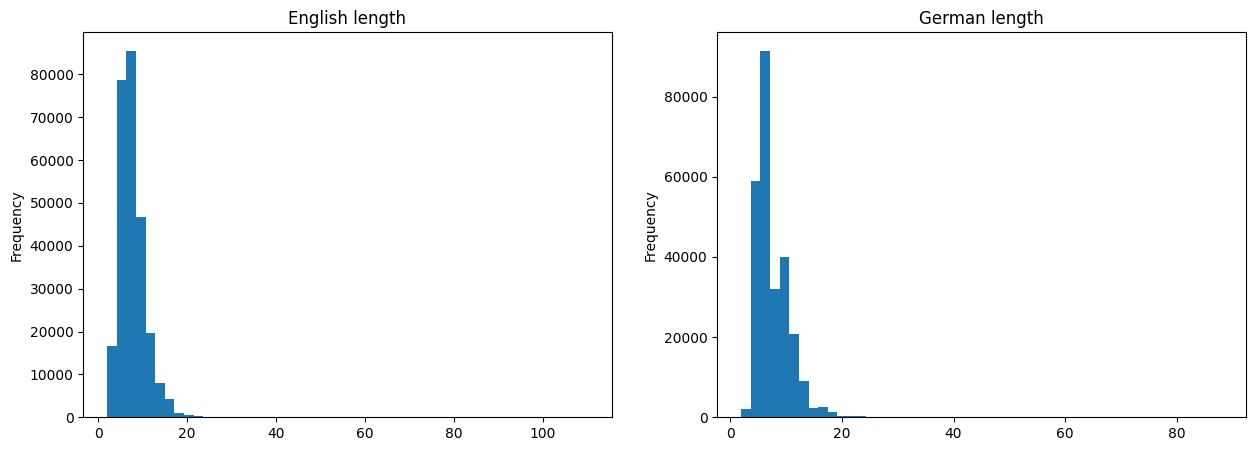

In [6]:
# visualize sentence lengths
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

df["eng"].apply(lambda x: len(x.split(" "))).plot(kind="hist", bins=50, ax=axs[0], title="English length")
df["ger"].apply(lambda x: len(x.split(" "))).plot(kind="hist", bins=50, ax=axs[1], title="German length")
plt.show()

In [7]:
eng_max_len = 20
ger_max_len = 20

df = df[df["eng"].apply(lambda x: len(x.split(" "))) <= eng_max_len]
df = df[df["ger"].apply(lambda x: len(x.split(" "))) <= ger_max_len]

df.shape

(260372, 2)

## German Tokenization and Embedding

In [8]:
ger_max_len += 2

# add the start and end tokens
df["ger"] = df["ger"].apply(lambda x: "<sos> " + x + " <eos>")

<ipython-input-8-7e3a988593c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ger"] = df["ger"].apply(lambda x: "<sos> " + x + " <eos>")


In [9]:
# make german tokenizer
ger_tokenizer = Tokenizer(filters="", oov_token="<unk>")
ger_tokenizer.fit_on_texts(df["ger"].values)

# add padding and start/end tokens
ger_tokenizer.word_index["<pad>"] = 0
ger_tokenizer.index_word[0] = "<pad>"
ger_vocab_size = len(ger_tokenizer.word_index)

ger_vocab_size

36883

In [10]:
target = ger_tokenizer.texts_to_sequences(df["ger"].values)

# padd sequences to max length
target = pad_sequences(target, padding="post", maxlen=ger_max_len)

target

array([[    2,   591,     4, ...,     0,     0,     0],
       [    2,  1760,    25, ...,     0,     0,     0],
       [    2,  4511,  1497, ...,     0,     0,     0],
       ...,
       [    2,    20,    35, ...,     4,     3,     0],
       [    2,    11, 36875, ...,     0,     0,     0],
       [    2, 14915, 36879, ..., 15318,     4,     3]], dtype=int32)

In [1]:
!curl -O https://int-emb-glove-de-wiki.s3.eu-central-1.amazonaws.com/vectors.txt -o vectors.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3571M  100 3571M    0     0  8777k      0  0:06:56  0:06:56 --:--:-- 8552k    0  0:06:42  0:00:13  0:06:29 9154k8  0:00:19  0:06:39 8031k0     0  8835k      0  0:06:53  0:02:19  0:04:34 10.5M     0  0:06:51  0:02:48  0:04:03 7932k  0:03:48  0:03:09 7444k 0:04:11  0:02:44 9635k0  8814k      0  0:06:54  0:04:24  0:02:30 9237k32k8841k      0  0:06:53  0:05:56  0:00:57 7487k3  0:06:03  0:00:50 7996k   0  8804k      0  0:06:55  0:06:41  0:00:14 8640k06:56  0:06:52  0:00:04 8124k


In [4]:
# load the glove embeddings
embeddings_index = {}
with open("vectors.txt", encoding="utf8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

1309281it [00:44, 29306.45it/s]

Found 1309281 word vectors.


In [5]:
# make the embedding matrix
ger_embedding_dim = 300
ger_embedding_matrix = np.zeros((ger_vocab_size, ger_embedding_dim))
for word, i in tqdm(ger_tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        ger_embedding_matrix[i] = embedding_vector

ger_embedding_matrix.shape

NameError: name 'ger_vocab_size' is not defined

## English Tokenization and Embedding

In [11]:
# make english tokenizer
eng_tokenizer = Tokenizer(filters="", oov_token="<unk>")
eng_tokenizer.fit_on_texts(df["eng"].values)

# add padding
eng_tokenizer.word_index["<pad>"] = 0
eng_tokenizer.index_word[0] = "<pad>"
eng_vocab_size = len(eng_tokenizer.word_index)

In [12]:
features = eng_tokenizer.texts_to_sequences(df["eng"].values)

# padd sequences to max length
features = pad_sequences(features, padding="post", maxlen=eng_max_len)

features

array([[   55,     2,     0, ...,     0,     0,     0],
       [ 2156,     2,     0, ...,     0,     0,     0],
       [ 2156,     2,     0, ...,     0,     0,     0],
       ...,
       [   17,     7,    14, ...,  4837,     2,     0],
       [    7, 16336,  2446, ...,    37,   968,     2],
       [ 9158, 16337,  2825, ...,     0,     0,     0]], dtype=int32)

In [13]:
!curl https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip -o glove.6B.zip
!unzip -q glove.6B.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  822M  100  822M    0     0  5252k      0  0:02:40  0:02:40 --:--:-- 5201k


In [14]:
# load the glove embeddings
embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

400000it [00:09, 41225.52it/s]

Found 400000 word vectors.


In [15]:
# make the embedding matrix
eng_embedding_dim = 100
eng_embedding_matrix = np.zeros((eng_vocab_size, eng_embedding_dim))
for word, i in tqdm(eng_tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        eng_embedding_matrix[i] = embedding_vector

eng_embedding_matrix.shape

100%|██████████| 16340/16340 [00:00<00:00, 464149.53it/s]


(16340, 100)

## Split data

In [16]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((208297, 20), (52075, 20), (208297, 22), (52075, 22))

## Model

In [19]:
# make a seq2seq encoder decoder model

class Seq2SeqModel(tf.keras.Model):
    def __init__(self, in_embedding_matrix, out_embedding_matrix, hidden_units):
        super(Seq2SeqModel, self).__init__()
        in_vocab_size, in_embedding_dim = in_embedding_matrix.shape
        out_vocab_size, out_embedding_dim = out_embedding_matrix.shape

        self.in_embedding = tf.keras.layers.Embedding(in_vocab_size, in_embedding_dim, weights=[in_embedding_matrix], trainable=False)
        self.out_embedding = tf.keras.layers.Embedding(out_vocab_size, out_embedding_dim, weights=[out_embedding_matrix], trainable=False)
        self.encoder = tf.keras.layers.LSTM(hidden_units, return_state=True)
        self.decoder = tf.keras.layers.LSTM(hidden_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(out_vocab_size)

    def call(self, inputs):
        encoder_inputs, decoder_inputs = inputs

        encoder_embed = self.in_embedding(encoder_inputs)
        in_mask = tf.math.logical_not(tf.math.equal(encoder_inputs, 0))
        _, state_h, state_c = self.encoder(encoder_embed, mask=in_mask)

        decoder_embed = self.out_embedding(decoder_inputs)
        out_mask = tf.math.logical_not(tf.math.equal(decoder_inputs, 0))
        decoder_outputs, _, _ = self.decoder(decoder_embed, initial_state=[state_h, state_c], mask=out_mask)

        logits = self.dense(decoder_outputs)
        return logits

    def translate(self, seqeunces):
        encoder_embed = self.in_embedding(seqeunces)
        _, state_h, state_c = self.encoder(encoder_embed)

        decoder_inputs = tf.expand_dims([ger_tokenizer.word_index["<sos>"]] * seqeunces.shape[0], 1)
        decoder_embed = self.out_embedding(decoder_inputs)

        outputs = []
        for _ in range(ger_max_len):
            decoder_outputs, state_h, state_c = self.decoder(decoder_embed, initial_state=[state_h, state_c])
            logits = self.dense(decoder_outputs)
            prediction = tf.argmax(logits, -1)
            outputs.append(prediction)
            decoder_embed = self.out_embedding(prediction)

        return tf.squeeze(outputs).numpy().T

# hyperparameters
hidden_units = 100
batch_size = 128
epochs = 10
validation_split = 0.2
ger_embedding_dim = 100

# make the model
model = Seq2SeqModel(eng_embedding_matrix, ger_embedding_matrix, hidden_units)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

# build and summarize the model
model.build(input_shape=[[None, eng_max_len], [None, ger_max_len]])
model.summary()

Model: "seq2_seq_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  1634000   
                                                                 
 embedding_3 (Embedding)     multiple                  368830    
                                                                 
 lstm_2 (LSTM)               multiple                  4440      
                                                                 
 lstm_3 (LSTM)               multiple                  840       
                                                                 
 dense_1 (Dense)             multiple                  405713    
                                                                 
Total params: 2,413,823
Trainable params: 779,823
Non-trainable params: 1,634,000
_________________________________________________________________


In [31]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
hist = model.fit(
    [features_train, target_train[:, :-1]],
    target_train.reshape(target_train.shape[0], target_train.shape[1], 1)[:, 1:],
    epochs=epochs, batch_size=batch_size, validation_split=validation_split)

Epoch 11/20
1302/1302 [==============================] - 129s 99ms/step - loss: 3.4855 - accuracy: 0.4539 - val_loss: 3.5903 - val_accuracy: 0.4514
Epoch 12/20
1302/1302 [==============================] - 128s 98ms/step - loss: 3.4492 - accuracy: 0.4570 - val_loss: 3.5661 - val_accuracy: 0.4540
Epoch 13/20
1302/1302 [==============================] - 128s 98ms/step - loss: 3.4171 - accuracy: 0.4599 - val_loss: 3.5437 - val_accuracy: 0.4556
Epoch 14/20
1302/1302 [==============================] - 128s 98ms/step - loss: 3.3881 - accuracy: 0.4623 - val_loss: 3.5244 - val_accuracy: 0.4571
Epoch 15/20
1302/1302 [==============================] - 127s 97ms/step - loss: 3.3605 - accuracy: 0.4646 - val_loss: 3.5039 - val_accuracy: 0.4596
Epoch 16/20
1302/1302 [==============================] - 128s 98ms/step - loss: 3.3353 - accuracy: 0.4668 - val_loss: 3.4873 - val_accuracy: 0.4607
Epoch 17/20
1302/1302 [==============================] - 127s 98ms/step - loss: 3.3134 - accuracy: 0.4685 - val_

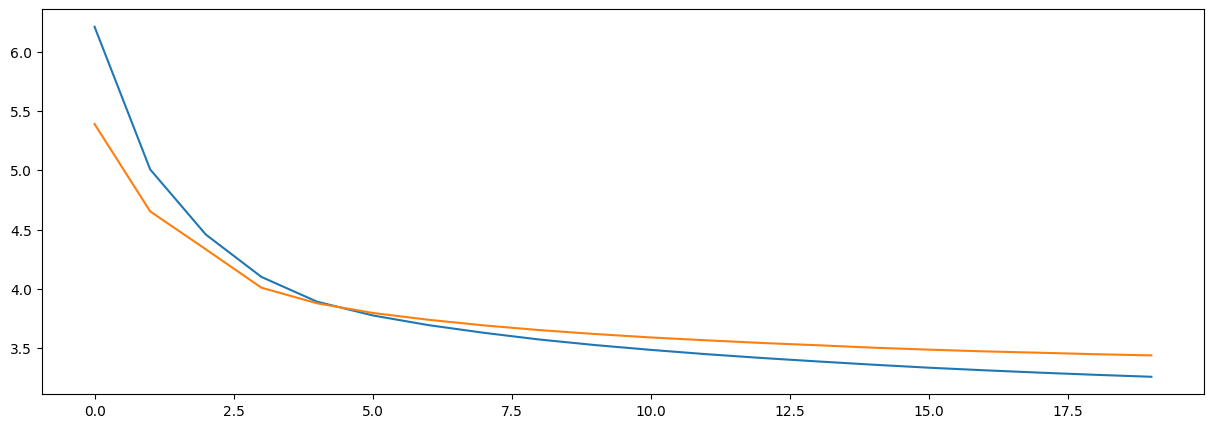

In [42]:
history = hist.history

plt.figure(figsize=(15, 5))
plt.plot(history["loss"], label="Training loss")
plt.plot(history["val_loss"], label="Validation loss")

In [35]:
model.evaluate(
    [features_test, target_test[:, :-1]],
    target_test.reshape(target_test.shape[0], target_test.shape[1], 1)[:, 1:]
)

1628/1628 [==============================] - 48s 29ms/step - loss: 3.4400 - accuracy: 0.4647


[3.4400265216827393, 0.464744508266449]

In [36]:
from google.colab import files

# save model weights and config
model.save_weights('model_weights.h5')

with open('model_config.json', 'w') as json_file:
    json_file.write(model.to_json())

# download model weights and config
files.download('model_config.json')
files.download('model_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
def translate(eng_sentence: str) -> str:
    """
    Translates an english sentence to german
    """

    eng_sentence = prep(eng_sentence)
    eng_sentence = eng_tokenizer.texts_to_sequences([eng_sentence])
    eng_sentence = pad_sequences(eng_sentence, padding="post", maxlen=eng_max_len)
    eng_sentence = tf.convert_to_tensor(eng_sentence)

    ger_sentence = model.translate(eng_sentence)[None, :]
    ger_sentence = ger_tokenizer.sequences_to_texts(ger_sentence)
    ger_sentence = " ".join(ger_sentence)

    return ger_sentence

In [43]:
print(translate("i like neural machine translation!"))

er ist ein buch in der schule in der schule in der schule mit tom in der schule in der schule in


In [44]:
print(translate("What is your favourite movie"))

wann ist ein buch in einem tasse ein buch in der schule in der schule in der schule in boston zu essen


In [45]:
print(translate("What is your favourite movie?"))

wie viele der hund ist eine tasse sehr sehr sehr sehr guter sehr gute sehr sehr sehr . <eos> <pad> <pad> ist
